In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ece44f81-e4cb-437c-ad08-1b3854a056e9', project_access_token='p-3024afa7611eda9d0c75372149b9a8a0f0cfcf2a')
pc = project.project_context

# Credenciales para correr CPLEX en la nube:
url='https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/'
key='api_13844083-bb29-4ff8-9481-c659c1338785'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

In [4]:
# Importamos el repositorio:
!pip install torch
!git clone https://github.com/AHuaman/attention-learn-to-route.git
!ls

    100% |████████████████████████████████| 676.9MB 63kB/s  eta 0:00:011             | 21.7MB 47.1MB/s eta 0:00:14    34% |███████████                     | 234.6MB 88.4MB/s eta 0:00:06    38% |████████████▏                   | 257.8MB 88.8MB/s eta 0:00:05ta 0:00:13   | 320.4MB 93.5MB/s eta 0:00:04    53% |█████████████████               | 360.9MB 25.1MB/s eta 0:00:13[K    54% |█████████████████▍              | 367.0MB 87.6MB/s eta 0:00:04    54% |█████████████████▌              | 369.9MB 87.5MB/s eta 0:00:0457% |██████████████████▌             | 390.4MB 88.3MB/s eta 0:00:04�████████████▎           | 429.7MB 91.0MB/s eta 0:00:03 |████████████████████▊           | 438.4MB 83.1MB/s eta 0:00:03MB 90.4MB/s eta 0:00:03MB 82.1MB/s eta 0:00:033MB 13.8MB/s eta 0:00:178.1MB/s eta 0:00:03��████████▊          | 459.8MB 90.9MB/s eta 0:00:03█████████▉          | 462.6MB 84.4MB/s eta 0:00:03██▏         | 467.7MB 89.0MB/s eta 0:00:03██████████████████▎         | 470.8MB 88.8MB/s eta 0:00:03██████████

In [5]:
# Probando la descarga de elementos para asegurarnos que funciona!
# df = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[16,17,18]], columns=['a','b','c'])
# project.save_data(data=df.to_csv(index=False), file_name='aea.csv', overwrite=True)
# objeto = [[1,2,3],['a','b','c'],[4.3,1.2,5.6]]
# project.save_data(data=pickle.dumps(objeto),file_name='object.pkl',overwrite=True)

In [6]:
!ls

attention-learn-to-route


In [7]:
path = 'attention-learn-to-route'
os.listdir(path)
os.chdir(path)

In [8]:
os.listdir()

['reinforce_baselines.py',
 'LICENSE',
 'programacion_lineal',
 'eval.py',
 'README.md',
 'paper_original',
 'Experimentos con CPLEX.ipynb',
 'environment.yml',
 'plot_vrp.ipynb',
 '4. Análisis de resultados.ipynb',
 'datos_generados',
 'train.py',
 '.git',
 '.ipynb_checkpoints',
 'run.py',
 'nets',
 'funciones_personalizadas.py',
 'utils',
 '.gitignore',
 '2. Generación y carga de muestras.ipynb',
 '1. Probando inferencia con modelos pre entrenados.ipynb',
 'images',
 'problems',
 'pretrained',
 'generate_data.py',
 'options.py']

In [9]:
os.listdir('programacion_lineal')

['Ejemplos para que usted pueda practicar',
 'desktop.ini',
 'cvrp_mtz.png',
 'funciones_docplex.py',
 'Modelos de Ruteo a través de docplex en Python.ipynb',
 'Modelos de Ruteo a través de docplex en Python.html']

In [10]:
# Cargamos las librerías necesarias:
from funciones_personalizadas import generar_un_grafo_personalizable, generar_vrp_personalizable
from funciones_personalizadas import plot_muestra_varios_grafos, crear_y_guardar_datasets
from funciones_personalizadas import modified_plot_vehicle_routes

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data_utils import save_dataset
from utils.data_utils import load_dataset

import networkx as nx
from programacion_lineal.funciones_docplex import GenerarTablaDistancias, AdaptarDataFrameLocalidades
from programacion_lineal.funciones_docplex import CrearCVRPOptimizarObtenerViajesPlotearGrafo

In [124]:
def DecodificarRutasCplex(matriz_viajes):
    acumulador_rutas = []
    for i in np.argwhere(matriz_viajes.iloc[0,:]).ravel():
        acumulador_rutas.append(i)
        j = i #inicializamos este valor
        while j!=0:
            j = np.argwhere(matriz_viajes.iloc[j,:]).ravel()[0]
            acumulador_rutas.append(j)
    return acumulador_rutas

def ResolverLoteConCplex(all_datasets_list, str_nombre_depot, num_rutas, capacidad_vehiculo, limite_mins=9999999,
                         limite_porc_optim=None, url=None, key=None, log_output=True):
    contador = 1
    acumulador_soluciones = []
    for i in all_datasets_list:
        print("############## \n GRAFO {}/{} \n##############".format(contador, len(all_datasets_list)))
        # Adaptar dataframe:
        df_localidades = AdaptarDataFrameLocalidades(i)
        matriz_distancias = GenerarTablaDistancias(df_localidades, df_localidades.index)
        # Resolver modelo lineal:
        modelo_cplex, viajes_cplex, grafo_cplex = CrearCVRPOptimizarObtenerViajesPlotearGrafo(
            dataframe_distancias=matriz_distancias, etiquetas_nodos=list(map(str,df_localidades.index)), 
            str_nombre_depot=str_nombre_depot, num_rutas=num_rutas, capacidad_vehiculo=capacidad_vehiculo, 
            serie_demandas_nodos=df_localidades['demanda'], str_nombre_modelo='cvrp_cplex',
            limite_mins = limite_mins, limite_porc_optim=limite_porc_optim, url=url, key=key, log_output=log_output
        )
        # Obtener objetivo y porcentaje de optimalidad:
        valor_obj = modelo_cplex.objective_value
        #porc_optim = modelo_cplex.get_cplex().solution.MIP.get_mip_relative_gap()
        #best_solution = modelo_cplex.get_cplex().solution.MIP.get_best_objective()
        str_soluc = str(modelo_cplex.get_solve_details())
        str_soluc = str_soluc[str_soluc.find('gap'):]
        porc_optim = float(str_soluc[str_soluc.find('=')+2:str_soluc.find('%')])/100
        # Obtener rutas generadas:
        secuencia_rutas = DecodificarRutasCplex(matriz_viajes=viajes_cplex)
        # Obtener tiempo de resolución en segundos:
        tiempo_ejec = modelo_cplex.solve_details.time
        # Se junta todo como una tupla por instancia
        acumulador_soluciones.append(tuple([valor_obj, secuencia_rutas, tiempo_ejec, porc_optim])) # el 'porc_optim' es un extra! OJO
        contador += 1
    # Damos una forma similar a los archivos obtenidos mediante el modelo neuronal:
    acumulador_soluciones = tuple([acumulador_soluciones, 1024])
    return acumulador_soluciones

In [111]:
# Generando varios datasets:
# Ahora se generan grafos y se graban en la computadora:

# EXPERIMENTO 1
crear_y_guardar_datasets(dataset_size=30, vrp_size=20, capacity=30, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=123, datadir='datos_generados',
                         name='EXP1_primero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=35, capacity=35, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=124, datadir='datos_generados',
                         name='EXP1_segundo', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=50, capacity=40, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=125, datadir='datos_generados',
                         name='EXP1_tercero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=75, capacity=45, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=126, datadir='datos_generados',
                         name='EXP1_cuarto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=100, capacity=50, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=127, datadir='datos_generados',
                         name='EXP1_quinto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=150, capacity=60, n_clusters=None, perc_clustered_points=0,
                         demands_distribution='integer_uniform', seed=128, datadir='datos_generados',
                         name='EXP1_sexto', low=1, high=10)

# EXPERIMENTO 3: CLUSTERS
crear_y_guardar_datasets(dataset_size=30, vrp_size=20, capacity=30, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=129, datadir='datos_generados',
                         name='EXP3_2_primero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=35, capacity=35, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=130, datadir='datos_generados',
                         name='EXP3_2_segundo', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=50, capacity=40, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=131, datadir='datos_generados',
                         name='EXP3_2_tercero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=75, capacity=45, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=132, datadir='datos_generados',
                         name='EXP3_2_cuarto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=100, capacity=50, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=133, datadir='datos_generados',
                         name='EXP3_2_quinto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=150, capacity=60, n_clusters=2, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=134, datadir='datos_generados',
                         name='EXP3_2_sexto', low=1, high=10)

crear_y_guardar_datasets(dataset_size=30, vrp_size=20, capacity=30, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=135, datadir='datos_generados',
                         name='EXP3_3_primero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=35, capacity=35, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=136, datadir='datos_generados',
                         name='EXP3_3_segundo', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=50, capacity=40, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=137, datadir='datos_generados',
                         name='EXP3_3_tercero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=75, capacity=45, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=138, datadir='datos_generados',
                         name='EXP3_3_cuarto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=100, capacity=50, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=139, datadir='datos_generados',
                         name='EXP3_3_quinto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=150, capacity=60, n_clusters=3, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=140, datadir='datos_generados',
                         name='EXP3_3_sexto', low=1, high=10)

crear_y_guardar_datasets(dataset_size=30, vrp_size=20, capacity=30, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=141, datadir='datos_generados',
                         name='EXP3_4_primero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=35, capacity=35, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=142, datadir='datos_generados',
                         name='EXP3_4_segundo', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=50, capacity=40, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=143, datadir='datos_generados',
                         name='EXP3_4_tercero', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=75, capacity=45, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=144, datadir='datos_generados',
                         name='EXP3_4_cuarto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=100, capacity=50, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=145, datadir='datos_generados',
                         name='EXP3_4_quinto', low=1, high=10)
crear_y_guardar_datasets(dataset_size=30, vrp_size=150, capacity=60, n_clusters=4, perc_clustered_points=0.75,
                         demands_distribution='integer_uniform', seed=146, datadir='datos_generados',
                         name='EXP3_4_sexto', low=1, high=10)

Grabando archivo datos_generados/VRP_20_EXP1_primero_seed123.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_35_EXP1_segundo_seed124.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_50_EXP1_tercero_seed125.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_75_EXP1_cuarto_seed126.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_100_EXP1_quinto_seed127.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_150_EXP1_sexto_seed128.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_20_EXP3_2_primero_seed129.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_35_EXP3_2_segundo_seed130.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_50_EXP3_2_tercero_seed131.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_75_EXP3_2_cuarto_seed132.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_100_EXP3_2_quinto_seed133.pkl con 30 grafos
Listo!
Grabando archivo datos_generados/VRP_150_EXP3_2

In [112]:
!ls datos_generados

VRP_100_EXP1_quinto_seed127.pkl    VRP_20_prueba_vrp20_seed1234.pkl
VRP_100_EXP3_2_quinto_seed133.pkl  VRP_35_EXP1_segundo_seed124.pkl
VRP_100_EXP3_3_quinto_seed139.pkl  VRP_35_EXP3_2_segundo_seed130.pkl
VRP_100_EXP3_4_quinto_seed145.pkl  VRP_35_EXP3_3_segundo_seed136.pkl
VRP_150_EXP1_sexto_seed128.pkl	   VRP_35_EXP3_4_segundo_seed142.pkl
VRP_150_EXP3_2_sexto_seed134.pkl   VRP_50_EXP1_tercero_seed125.pkl
VRP_150_EXP3_3_sexto_seed140.pkl   VRP_50_EXP3_2_tercero_seed131.pkl
VRP_150_EXP3_4_sexto_seed146.pkl   VRP_50_EXP3_3_tercero_seed137.pkl
VRP_200_cuarta_prueba_seed15.pkl   VRP_50_EXP3_4_tercero_seed143.pkl
VRP_20_EXP1_primero_seed123.pkl    VRP_75_EXP1_cuarto_seed126.pkl
VRP_20_EXP3_2_primero_seed129.pkl  VRP_75_EXP3_2_cuarto_seed132.pkl
VRP_20_EXP3_3_primero_seed135.pkl  VRP_75_EXP3_3_cuarto_seed138.pkl
VRP_20_EXP3_4_primero_seed141.pkl  VRP_75_EXP3_4_cuarto_seed144.pkl


In [113]:
# Todos los datasets:
# lista_files = [
#     'datos_generados/VRP_20_EXP1_primero_seed123.pkl','datos_generados/VRP_35_EXP1_segundo_seed124.pkl',
#     'datos_generados/VRP_50_EXP1_tercero_seed125.pkl','datos_generados/VRP_75_EXP1_cuarto_seed126.pkl',
#     'datos_generados/VRP_100_EXP1_quinto_seed127.pkl','datos_generados/VRP_150_EXP1_sexto_seed128.pkl',
#     'datos_generados/VRP_20_EXP3_2_primero_seed129.pkl','datos_generados/VRP_35_EXP3_2_segundo_seed130.pkl',
#     'datos_generados/VRP_50_EXP3_2_tercero_seed131.pkl','datos_generados/VRP_75_EXP3_2_cuarto_seed132.pkl',
#     'datos_generados/VRP_100_EXP3_2_quinto_seed133.pkl','datos_generados/VRP_150_EXP3_2_sexto_seed134.pkl',
#     'datos_generados/VRP_20_EXP3_3_primero_seed135.pkl','datos_generados/VRP_35_EXP3_3_segundo_seed136.pkl',
#     'datos_generados/VRP_50_EXP3_3_tercero_seed137.pkl','datos_generados/VRP_75_EXP3_3_cuarto_seed138.pkl',
#     'datos_generados/VRP_100_EXP3_3_quinto_seed139.pkl','datos_generados/VRP_150_EXP3_3_sexto_seed140.pkl',
#     'datos_generados/VRP_20_EXP3_4_primero_seed141.pkl','datos_generados/VRP_35_EXP3_4_segundo_seed142.pkl',
#     'datos_generados/VRP_50_EXP3_4_tercero_seed143.pkl','datos_generados/VRP_75_EXP3_4_cuarto_seed144.pkl',
#     'datos_generados/VRP_100_EXP3_4_quinto_seed145.pkl','datos_generados/VRP_150_EXP3_4_sexto_seed146.pkl'
# ]

# Todos los que correré:
lista_files = [
    'datos_generados/VRP_20_EXP1_primero_seed123.pkl','datos_generados/VRP_35_EXP1_segundo_seed124.pkl',
    'datos_generados/VRP_50_EXP1_tercero_seed125.pkl',
    'datos_generados/VRP_20_EXP3_2_primero_seed129.pkl','datos_generados/VRP_35_EXP3_2_segundo_seed130.pkl',
    'datos_generados/VRP_50_EXP3_2_tercero_seed131.pkl',
    'datos_generados/VRP_20_EXP3_3_primero_seed135.pkl','datos_generados/VRP_35_EXP3_3_segundo_seed136.pkl',
    'datos_generados/VRP_50_EXP3_3_tercero_seed137.pkl',
    'datos_generados/VRP_20_EXP3_4_primero_seed141.pkl','datos_generados/VRP_35_EXP3_4_segundo_seed142.pkl',
    'datos_generados/VRP_50_EXP3_4_tercero_seed143.pkl',
] # 12 files

# Listo:
# lista_files = [
#     'datos_generados/VRP_20_EXP1_primero_seed123.pkl'
# ]

# # Pendientes:
# lista_files = [
# #     'datos_generados/VRP_20_EXP1_primero_seed123.pkl',
# #     'datos_generados/VRP_20_EXP3_2_primero_seed129.pkl',
#     'datos_generados/VRP_20_EXP3_3_primero_seed135.pkl',
#     'datos_generados/VRP_20_EXP3_4_primero_seed141.pkl'
# ] # Correr en local

# Todos los que correré:
# lista_files = [
#     'datos_generados/VRP_35_EXP1_segundo_seed124.pkl',
#     'datos_generados/VRP_50_EXP1_tercero_seed125.pkl',
#     'datos_generados/VRP_35_EXP3_2_segundo_seed130.pkl',
#     'datos_generados/VRP_50_EXP3_2_tercero_seed131.pkl',
#     'datos_generados/VRP_20_EXP3_3_primero_seed135.pkl','datos_generados/VRP_35_EXP3_3_segundo_seed136.pkl',
#     'datos_generados/VRP_50_EXP3_3_tercero_seed137.pkl',
#     'datos_generados/VRP_20_EXP3_4_primero_seed141.pkl','datos_generados/VRP_35_EXP3_4_segundo_seed142.pkl',
#     'datos_generados/VRP_50_EXP3_4_tercero_seed143.pkl',
# ] # 12 files

In [114]:
len(lista_files) * 30 * 20 / 60 /24 # dias

0.4166666666666667

 ################################## RESOLVIENDO  datos_generados/VRP_20_EXP1_primero_seed123.pkl  ##################################
############## 
 GRAFO 1/30 
##############
========================= CREANDO MODELO =========================
Model: cvrp_cplex
 - number of variables: 440
   - binary=420, integer=0, continuous=20
 - number of constraints: 424
   - linear=424
 - parameters: defaults
None
======================= OPTIMIZANDO MODELO =======================
[2019-06-11T00:43:52Z, INFO] CPLEX version 12090000
[2019-06-11T00:43:52Z, INFO] Parameter file:
[2019-06-11T00:43:52Z, INFO] # -- This content is generated by DOcplex
[2019-06-11T00:43:52Z, INFO] CPLEX Parameter File Version 12.8.0.0
[2019-06-11T00:43:52Z, INFO] CPX_PARAM_TILIM                  60.00000000000000
[2019-06-11T00:43:52Z, INFO] # --- end of generated prm data ---
[2019-06-11T00:43:52Z, WARN] Warning:  CPLEX version found in file python_cvrp_cplex.prm (12.8.0.0) does not match
[2019-06-11T00:43:52Z, WARN]   

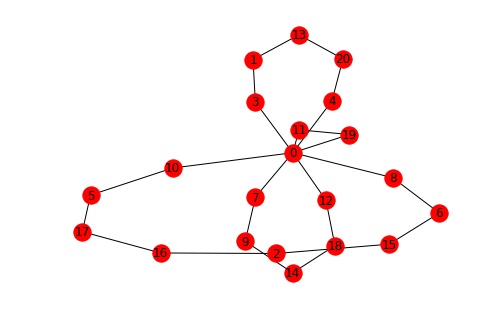

In [116]:
for i in lista_files:
    print(' ################################## RESOLVIENDO ',i,' ##################################')
    carga_actual = load_dataset(i)
    solucion_cplex = ResolverLoteConCplex(all_datasets_list=carga_actual, str_nombre_depot='0',
                                          num_rutas='auto_1.2_trivial', capacidad_vehiculo=carga_actual[0][3],
                                          limite_mins = 1, url=url, key=key)
#     project.save_data(data=pickle.dumps(solucion_cplex),file_name='CPLEX_'+i.split('/')[-1],overwrite=True)

In [127]:
print(solucion_cplex[0][0][0][1])

[4, 20, 13, 1, 3, 0, 10, 5, 17, 16, 2, 15, 6, 8, 0, 12, 18, 14, 9, 7, 0, 19, 11, 0]


In [121]:
print(solucion_cplex[0][0][0][1])

[4, 20, 13, 1, 3, 0, 10, 5, 17, 16, 2, 15, 6, 8, 0, 12, 18, 14, 9, 7, 0, 19, 11, 0]
